# Sign Language Digits Classifier
Using MobileNet transfer learning to classify ASL digits (0-9)

## 1. Import Dependencies

In [ ]:
# Import dependencies
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

2025-12-18 14:08:08.847978: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-18 14:08:08.856323: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-18 14:08:09.122679: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-18 14:08:10.354951: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

## 2. Set Project Constants

In [ ]:
# Project constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
VALIDATION_SPLIT = 0.2
NUM_CLASSES = 10

# Paths
DATASET_PATH = 'Sign-Language-Digits-Dataset/Dataset'
TRAIN_PATH = 'Sign-Language-Digits-Dataset/training'
TEST_PATH = 'Sign-Language-Digits-Dataset/test'

## 3. Create Dataset Splits
Creating training/ folder (85% of dataset) and test/ folder (15% of dataset)

In [4]:
# Create training/ and test/ folders with 85/15 split
def create_train_test_split(source_path, train_path, test_path, test_split=0.15):
    """Split dataset into training (85%) and test (15%) folders"""
    
    # Remove destination folders if they exist
    for path in [train_path, test_path]:
        if os.path.exists(path):
            shutil.rmtree(path)
        os.makedirs(path)
    
    total_train_images = 0
    total_test_images = 0
    
    # Process each digit (0-9)
    for digit in range(10):
        digit_source = os.path.join(source_path, str(digit))
        digit_train = os.path.join(train_path, str(digit))
        digit_test = os.path.join(test_path, str(digit))
        
        os.makedirs(digit_train)
        os.makedirs(digit_test)
        
        # Get all images for this digit
        all_images = [f for f in os.listdir(digit_source) if f.endswith('.JPG')]
        
        # Shuffle images
        random.shuffle(all_images)
        
        # Calculate split point (15% for test, 85% for training)
        num_test = int(len(all_images) * test_split)
        num_train = len(all_images) - num_test
        
        # Split images
        test_images = all_images[:num_test]
        train_images = all_images[num_test:]
        
        # Copy test images
        for img in test_images:
            src = os.path.join(digit_source, img)
            dst = os.path.join(digit_test, img)
            shutil.copy2(src, dst)
        
        # Copy training images
        for img in train_images:
            src = os.path.join(digit_source, img)
            dst = os.path.join(digit_train, img)
            shutil.copy2(src, dst)
        
        total_train_images += num_train
        total_test_images += num_test
        
        print(f'Digit {digit}: {num_train} training, {num_test} test')
    
    return total_train_images, total_test_images

print('Creating training/test split...')
num_train, num_test = create_train_test_split(DATASET_PATH, TRAIN_PATH, TEST_PATH)

print(f'\nTotal training images: {num_train} ({num_train/(num_train+num_test)*100:.1f}%)')
print(f'Total test images: {num_test} ({num_test/(num_train+num_test)*100:.1f}%)')

Creating training/test split...
Digit 0: 175 training, 30 test
Digit 1: 176 training, 30 test
Digit 2: 176 training, 30 test
Digit 3: 176 training, 30 test
Digit 4: 176 training, 31 test
Digit 5: 176 training, 31 test
Digit 6: 176 training, 31 test
Digit 7: 176 training, 30 test
Digit 8: 177 training, 31 test
Digit 9: 174 training, 30 test

Total training images: 1758 (85.3%)
Total test images: 304 (14.7%)


## 4. Create Data Generators
Setting up training and validation generators with 80/20 split

In [5]:
# Create image data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    # Data augmentation parameters
    rotation_range=15,              # Randomly rotate images by up to 15 degrees
    zoom_range=0.15,                # Randomly zoom in/out by up to 15%
    brightness_range=[0.8, 1.2],    # Randomly adjust brightness
    fill_mode='nearest'             # Fill pixels after transformations
)

# Validation generator (no augmentation, only rescaling)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Validation generator
validation_generator = val_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

print(f'\nTraining samples: {train_generator.samples}')
print(f'Validation samples: {validation_generator.samples}')

Found 1409 images belonging to 10 classes.
Found 349 images belonging to 10 classes.

Training samples: 1409
Validation samples: 349


## 5. Build Model Architecture
Using MobileNetV2 as base model with frozen weights, adding custom classification head

In [8]:
# Import MobileNet and create model
print('Loading MobileNetV2...')
base_model = MobileNetV2(
    # input_shape=(100, 100, 3), 
    include_top=False, 
    weights='imagenet'
)

# Freeze base model layers
# base_model.trainable = False

# Get last 7 layers with more details
for layer in base_model.layers[-7:]:
    print(f"Layer: {layer.name}")
    print(f"  Type: {layer.__class__.__name__}")
    print(f"  Output Shape: {layer.output.shape}")
    print(f"  Params: {layer.count_params()}")
    print("-" * 50)

Loading MobileNetV2...


/tmp/ipykernel_1416434/1689098958.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Layer: block_16_depthwise_BN
  Type: BatchNormalization
  Output Shape: (None, None, None, 960)
  Params: 3840
--------------------------------------------------
Layer: block_16_depthwise_relu
  Type: ReLU
  Output Shape: (None, None, None, 960)
  Params: 0
--------------------------------------------------
Layer: block_16_project
  Type: Conv2D
  Output Shape: (None, None, None, 320)
  Params: 307200
--------------------------------------------------
Layer: block_16_project_BN
  Type: BatchNormalization
  Output Shape: (None, None, None, 320)
  Params: 1280
--------------------------------------------------
Layer: Conv_1
  Type: Conv2D
  Output Shape: (None, None, None, 1280)
  Params: 409600
--------------------------------------------------
Layer: Conv_1_bn
  Type: BatchNormalization
  Output Shape: (None, None, None, 1280)
  Params: 5120
--------------------------------------------------
Layer: out_relu
  Type: ReLU
  Output Shape: (None, None, None, 1280)
  Params: 0
-------------

In [ ]:
# Build model on top of MobileNet
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(
    NUM_CLASSES,
    activation='softmax',
    # kernel_regularizer=regularizers.l2(0.1)
)(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in model.layers[:-7]:
    layer.trainable = False

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print('\nModel architecture:')
# Get last 7 layers with more details
for layer in model.layers[-7:]:
    print(f"Layer: {layer.name}")
    print(f"  Type: {layer.__class__.__name__}")
    print(f"  Output Shape: {layer.output.shape}")
    print(f"  Params: {layer.count_params()}")
    print(f" Trainable: {layer.trainable}")
    print("-" * 50)

Layer: out_relu
  Type: ReLU
  Output Shape: (None, None, None, 1280)
  Params: 0
 Trainable: False
--------------------------------------------------
Layer: global_average_pooling2d_5
  Type: GlobalAveragePooling2D
  Output Shape: (None, 1280)
  Params: 0
 Trainable: False
--------------------------------------------------
Layer: dropout_5
  Type: Dropout
  Output Shape: (None, 1280)
  Params: 0
 Trainable: False
--------------------------------------------------
Layer: dense_5
  Type: Dense
  Output Shape: (None, 10)
  Params: 12810
 Trainable: True
--------------------------------------------------


## 6. Train Model

In [ ]:
# Train the model
print('Training model...')
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Training model...
Epoch 1/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 636ms/step - accuracy: 0.4870 - loss: 1.5191 - val_accuracy: 0.5819 - val_loss: 1.2674 - learning_rate: 1.0000e-04
Epoch 2/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 663ms/step - accuracy: 0.7792 - loss: 0.7021 - val_accuracy: 0.6039 - val_loss: 1.0714 - learning_rate: 1.0000e-04
Epoch 3/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 34s 661ms/step - accuracy: 0.8433 - loss: 0.5092 - val_accuracy: 0.6528 - val_loss: 0.9570 - learning_rate: 1.0000e-04
Epoch 4/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 34s 660ms/step - accuracy: 0.8730 - loss: 0.4281 - val_accuracy: 0.6748 - val_loss: 0.9081 - learning_rate: 1.0000e-04
Epoch 5/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 34s 660ms/step - accuracy: 0.8857 - loss: 0.3717 - val_accuracy: 0.6968 - val_loss: 0.8342 - learning_rate: 1.0000e-04
Epoch 6/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 34s 656ms/step - accuracy: 0.9093 - loss: 0.3197 - val_accuracy: 0.7311 - val_loss: 0.7576 - learning_rate: 1.0000e-04
Epoch 7/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 34

## 7. Visualize Training History

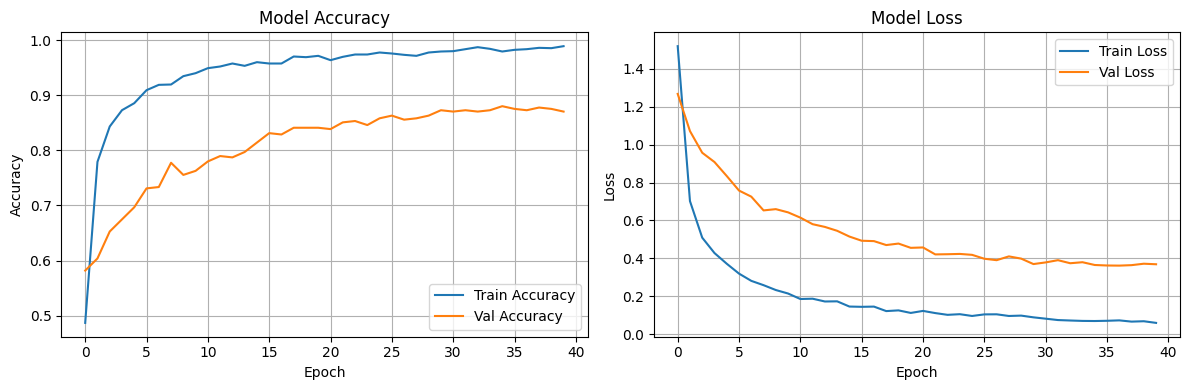

In [284]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 8. Evaluate Model
Testing on unseen eval dataset

In [ ]:
# Evaluate model on eval/ folder
eval_datagen = ImageDataGenerator(rescale=1./255)

eval_generator = eval_datagen.flow_from_directory(
    EVAL_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print('Evaluating model on eval dataset...')
eval_loss, eval_accuracy = model.evaluate(eval_generator)
print(f'\nEval Loss: {eval_loss:.4f}')
print(f'Eval Accuracy: {eval_accuracy:.4f}')

## 9. Confusion Matrix & Classification Report

In [ ]:
# Generate predictions for confusion matrix
eval_generator.reset()
predictions = model.predict(eval_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = eval_generator.classes

# Create confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix - Sign Language Digits')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, 
                          target_names=[str(i) for i in range(10)]))